#Paquetes necesarios

In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

## Tarea 1 - Captura una o varias imágenes con monedas no solapadas. 

Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

**Nota:** Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

**Extras:** Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

Tienes  0.0 €


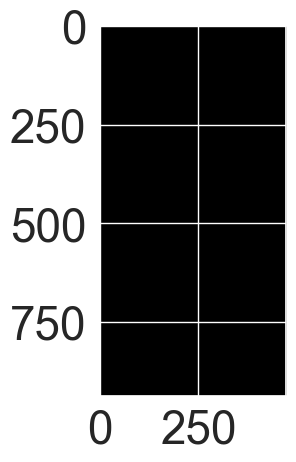

In [8]:
img = cv2.imread('Material P3/Monedas.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th,img_th = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#Obtiene únicamente los contornos externos
contornos, hierarchy = cv2.findContours(img_th, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

coin_sizes = {1: 16.26,
              2: 18.75,
              5: 21.25,
              10: 19.75,
              20: 22.25,
              50: 24.25,
              100: 23.25,
              200: 25.75}
# Pide el valor de la moneda a seleccionar al usuario
reference_diameter = coin_sizes[int(input("Seleccione el valor de la moneda de referencia (en centimos)"))]
coin_ratios = {int(round(16.26/reference_diameter,2)*100) : 1, 
               int(round(18.75/reference_diameter,2)*100): 2, 
               int(round(21.25/reference_diameter,2)*100): 5, 
               int(round(19.75/reference_diameter,2)*100): 10, 
               int(round(22.25/reference_diameter,2)*100): 20,
               int(round(24.25/reference_diameter,2)*100): 50,
               int(round(23.25/reference_diameter,2)*100): 100,
               int(round(25.75/reference_diameter,2)*100): 200}

# Pide que el usuario seleccione una moneda
ix = None
iy = None
clicked = False
def select_point(event,x,y,flags,param):
    global ix,iy,clicked
    if event == cv2.EVENT_LBUTTONDOWN: # captures left button double-click
        ix,iy = x,y
        clicked=True

cv2.imshow('Select reference coin',img)
cv2.setMouseCallback('Select reference coin', select_point)
while cv2.waitKey(20) != 27:
        if clicked:
             break
cv2.destroyAllWindows()


experimental_diameters = []
experimental_reference = None
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 10:
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        experimental_diameters.append(radio * 2)
        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
        if np.sqrt(np.power(ix-cx,2) + np.power(iy-cy, 2)) <= radio:
             experimental_reference = radio * 2

             
new_ratios = [element / experimental_reference for element in experimental_diameters]
money = 0
for ratio in new_ratios:
    money += coin_ratios[list(coin_ratios.keys())[np.argmin([abs(element - int(round(ratio,3)*100)) for element in coin_ratios.keys()])]]
plt.imshow(img_cont) 
print("Tienes ", money/100, "€")

El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV.

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Anotaciones  [0, 0, 0, 2, 0, 1, 2, 2, 2, 1, 2, 3, 0, 3, 1, 2, 0, 2, 3, 2, 3, 3, 3, 1, 1, 3, 0, 1, 1, 1, 1, 1, 3, 1, 0, 0, 0, 1, 3, 3, 3, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 1, 2, 3, 3, 0, 0, 3, 0, 0, 1, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 1, 0, 2, 3, 0, 3, 1, 3, 1, 0, 1, 3, 3, 1, 3, 0, 2, 0, 0, 3, 3, 3, 2, 0, 2, 0]
Predicciones  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 3, 3, 2, 0, 0, 0, 2, 2, 1, 1, 0, 3, 2, 3, 3, 3, 1, 2, 0, 2, 0, 2, 0, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 0, 0, 2, 1, 3, 3, 0, 3, 2, 1, 0, 2, 2, 2, 1, 2, 1, 0, 2, 0, 2, 3, 3, 1, 3, 3, 3, 3, 2, 0, 1, 0, 2, 1, 0, 0, 1, 2, 1, 1, 2, 1, 3, 2, 2, 0, 1, 2, 1, 0, 1, 3, 1, 2, 3, 1, 1]
¿Cómo de bien encajan anotación y predicción?
Accuracy (TP/(n))= 0.24
Precision (TP/(TP+FP)) = 0.24621007115489874
Recall (TP/(TP+FN)) = 0.24
F1 Score (2*(precision*recall)/(precision+recall)) = 0.2416160187278657


Text(38.25, 0.5, 'Real/Anotado')

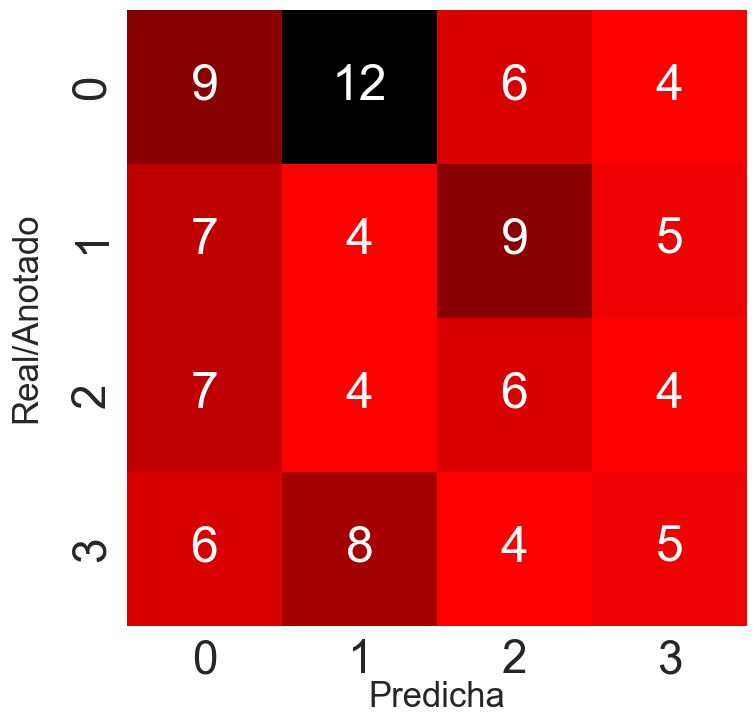

In [7]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)